In [211]:
import numpy as np
import pandas as pd
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

In [212]:
feature_data = pd.read_csv("datasets/h1n1/training_set_features.csv")
feature_data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [213]:
label_data = pd.read_csv("datasets/h1n1/training_set_labels.csv")
label_data

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [214]:
feature_data.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

# Helper functions

In [215]:
def ordinal_encode(df, column_name, categories_map):
    df[column_name] = df[column_name].map(categories_map)
    return df

In [216]:
def one_hot_encode(df, column_name):
    encoder = OneHotEncoder(sparse_output=False, drop=None)
    encoded_data = encoder.fit_transform(df[[column_name]])
    encoded_columns = encoder.get_feature_names_out([column_name])
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)
    df = df.drop(columns=[column_name])
    return pd.concat([df, encoded_df], axis=1)


In [217]:

# Encode age groups
age_codes = [['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']]
enc = OrdinalEncoder(categories=age_codes)
feature_data[['age_group']] = enc.fit_transform(feature_data[['age_group']])


In [218]:

# Encode education
education_map = {
    '< 12 Years': 0,
    '12 Years': 1,
    'College Graduate': 2,
    'Some College': 3
}
feature_data = ordinal_encode(feature_data, 'education', education_map)


In [219]:

# One-hot encode race
feature_data = one_hot_encode(feature_data, 'race')


In [220]:

# One-hot encode sex
feature_data = one_hot_encode(feature_data, 'sex')


In [221]:

# Encode income poverty
income_map = {
    'Below Poverty': 0,
    '<= $75,000, Above Poverty': 1,
    '> $75,000': 2
}
feature_data = ordinal_encode(feature_data, 'income_poverty', income_map)


In [222]:

# One-hot encode marital status
feature_data = one_hot_encode(feature_data, 'marital_status')


In [223]:

# Encode rent or own
rent_own_map = {'Own': 1, 'Rent': 0}
feature_data = ordinal_encode(feature_data, 'rent_or_own', rent_own_map)


In [224]:

# Encode employment status
employment_map = {
    'Employed': 2,
    'Unemployed': 0,
    'Not in Labor Force': 1
}
feature_data = ordinal_encode(feature_data, 'employment_status', employment_map)


In [225]:

# Encode census MSA
census_map = {
    'Non-MSA': 0,
    'MSA, Not Principle  City': 1,
    'MSA, Principle City': 2
}
feature_data = ordinal_encode(feature_data, 'census_msa', census_map)


In [226]:
feature_data['employment_industry'].unique()


array([nan, 'pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh',
       'ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf',
       'arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax',
       'dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo',
       'qnlwzans'], dtype=object)

In [227]:
feature_data['hhs_geo_region'].unique()


array(['oxchjgsf', 'bhuqouqj', 'qufhixun', 'lrircsnp', 'atmpeygn',
       'lzgpxyit', 'fpwskwrf', 'mlyzmhmf', 'dqpwygqj', 'kbazzjca'],
      dtype=object)

In [228]:
feature_data['employment_occupation'].unique()


array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [229]:
feature_data.drop(columns=['employment_industry', 'hhs_geo_region', 'employment_occupation'], inplace=True)

In [230]:
feature_data.dtypes

respondent_id                       int64
h1n1_concern                      float64
h1n1_knowledge                    float64
behavioral_antiviral_meds         float64
behavioral_avoidance              float64
                                   ...   
employment_occupation_xgwztkwe    float64
employment_occupation_xqwwgdyp    float64
employment_occupation_xtkaffoo    float64
employment_occupation_xzmlyyjv    float64
employment_occupation_nan         float64
Length: 95, dtype: object

In [231]:
imputer = IterativeImputer(
    random_state=42,
    max_iter=10,
    initial_strategy='mean',
    min_value=0,
    verbose=0
)
feature_data_imputed_array = imputer.fit_transform(feature_data)

In [232]:
feature_data = pd.DataFrame(feature_data_imputed_array, columns=feature_data.columns)
feature_data



,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26703,26703.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26704,26704.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26705,26705.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
X = feature_data.drop(['respondent_id'], axis=1)  # Drop ID column
y = label_data['h1n1_vaccine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [234]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [235]:
# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Average CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


Cross-validation ROC-AUC scores: [0.8491988  0.86014606 0.8655158  0.85977751 0.85418768]
Average CV ROC-AUC: 0.858 (+/- 0.011)


In [236]:

# Train the model on the full training set
rf_model.fit(X_train, y_train)


In [ ]:

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]


In [237]:

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4212
           1       0.58      0.67      0.62      1130

    accuracy                           0.83      5342
   macro avg       0.74      0.77      0.75      5342
weighted avg       0.84      0.83      0.83      5342

ROC-AUC Score: 0.863


In [238]:

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance


,feature,importance
9,doctor_recc_h1n1,0.184170
14,health_insurance,0.103706
16,opinion_h1n1_risk,0.101452
15,opinion_h1n1_vacc_effective,0.091842
19,opinion_seas_risk,0.055365
...,...,...
41,employment_industry_dotnnunm,0.000179
47,employment_industry_msuufmds,0.000127
49,employment_industry_phxvnwax,0.000079
82,employment_occupation_pvmttkik,0.000046


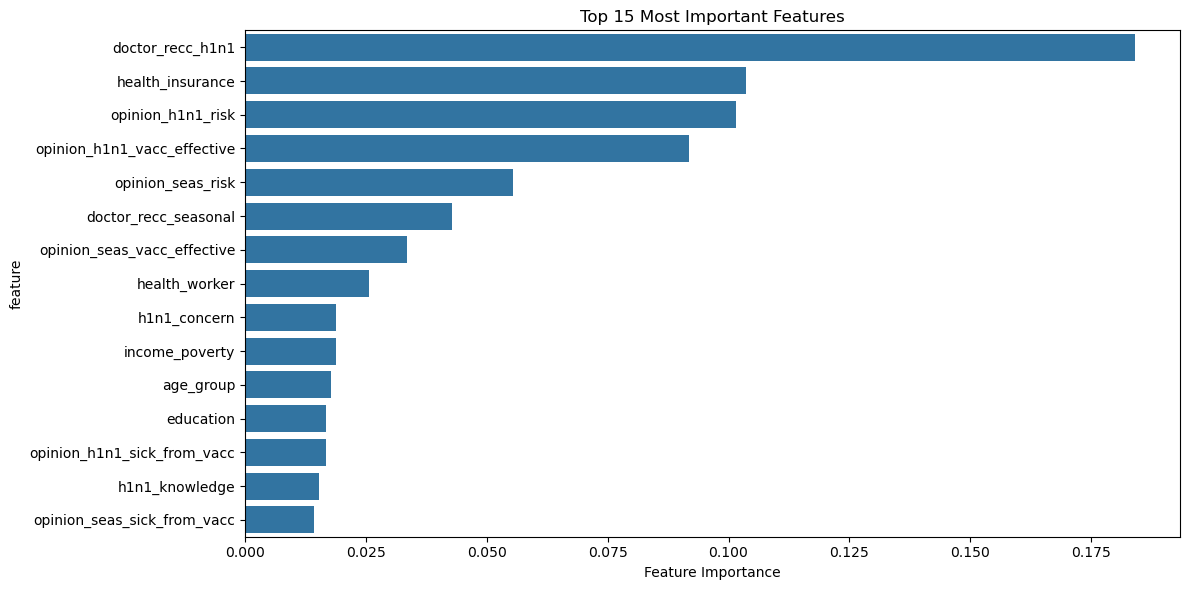

In [239]:
# Plot top 15 most important features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()


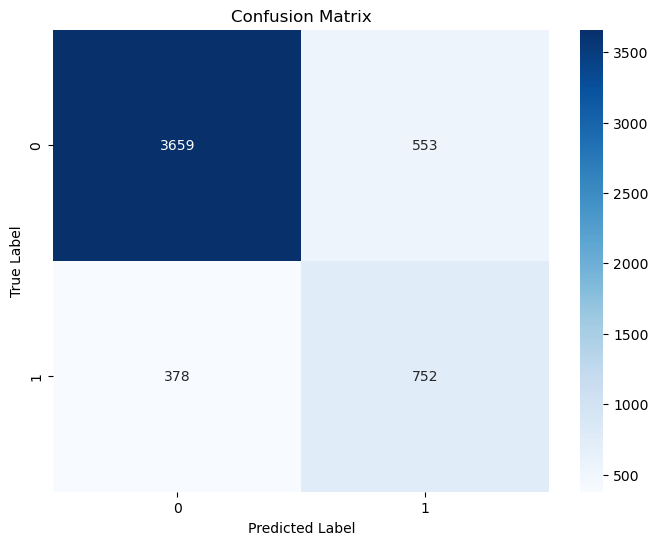

In [240]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()